This notebook implements strategy number 2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.grid import Grid
import random
import multiprocessing
from ipywidgets import IntProgress
from IPython.display import display
%matplotlib inline

As input data we use consumption/production of specific houses, that were found to have reasonable consumption/production quantities. Also we set the timeframe to a short one of two weeks, such that the genetic algorithm runs faster than for a whole year.

In [2]:
# Consumption data
df_cons = pd.read_csv('data/consumption_ausgrid.csv')
df_cons['Unnamed: 0'] = pd.to_datetime(df_cons['Unnamed: 0'])
df_cons = df_cons.set_index('Unnamed: 0')
df_cons_red = df_cons.iloc[:,0]
# Production data
df_prod = pd.read_csv('data/generation_ausgrid.csv')
df_prod['Unnamed: 0'] = pd.to_datetime(df_prod['Unnamed: 0'])
df_prod = df_prod.set_index('Unnamed: 0')

# Choose specific houses and time frame
#used_houses = [114,204,47,160,82,168]# Good ones, i.e. 
#used_houses = random.sample(list(np.arange(df_cons.shape[1])),40)
used_houses = [24, 30, 28, 8, 3, 33, 5, 21, 39, 11, 15, 17, 2, 36, 38, 6, 25, 16, 1, 32, 13, 10, 29, 20, 19, 22, 26, 18, 27, 14, 9, 31, 12, 0, 23, 37, 34, 4, 7, 35]

week_start = 37
week_end = 39
df_cons = df_cons.iloc[7*48*week_start:7*48*week_end,used_houses]
df_prod = df_prod.iloc[7*48*week_start:7*48*week_end,used_houses]

data_cons = df_cons.values
data_prod = df_prod.values

Now we can build the grid model. Since we only simulate 2 weeks, we need to set the costs accordingly. Therfore we define the timeframe after which the storages should pay off (i.e. 10 years) and calculate its investition cost for two weeks. 

In [3]:
# Create grid model
g = Grid(num_houses=df_cons.shape[1],
         num_storages=df_cons.shape[1],
         max_capacity=0,
         num_pvtypes=df_prod.shape[1],
         pv_peakpower=0)
# Add each pv type to each house
for i in range(df_cons.shape[1]):
    g.change_pvtype(num_house=i,pv_type=i)

# Set the costs for 2 weeks
amortization_timeframe = 10*365 # in days
storage_cost_per_kWh = 500
storage_cost_per_kWh_per_day = storage_cost_per_kWh / amortization_timeframe
cost_per_wire = 0 # Assume wires are already there
loss_per_unit = 0.05 # 5% of power lost, when transferring to direct neighbor
g.set_costs(cost_storage_kwh=14*storage_cost_per_kWh_per_day,loss_per_unit=loss_per_unit)
g_initial = g.get_copy()
# Simulate the grid
res_dict_wo_storage = g.simulate(data_cons=data_cons,data_prod=data_prod)
print(res_dict_wo_storage)

{'import_grid_kwh': 6358.398999999978, 'export_grid_kwh': 1735.215999999992, 'pv_production_kwh': 3481.3379999999825, 'setup_cost_storage': 0.0, 'setup_cost_pv': 0.0, 'cost_import_grid': 1589.5997499999944, 'reward_export_grid': 173.5215999999992}


As we can see there is something going on with pv production and export. We still need an objective function that returns the cost for running this kind of grid for the specific timeframe. In this case the objective function is really easy, since we already defined the cost for setting up the storages in this two week interval.

In [4]:
def objective_function(res_dict):
    return res_dict['cost_import_grid'] + res_dict['setup_cost_storage'] - res_dict['reward_export_grid']

# Calculate the cost of the above simulation
cost_wo_storage = objective_function(res_dict_wo_storage)
print('Cost without storage: ' + str(cost_wo_storage))

Cost without storage: 1416.0781499999953


We now create an artificial grid with a specific number of storages and sizes.

In [5]:
# Capacities to simulate
caps = np.linspace(0,5,20,dtype=float)

population_size = 50
population = []

# Create grid model
g = Grid(num_houses=df_cons.shape[1],
         num_storages=5,
         max_capacity=0,
         num_pvtypes=df_prod.shape[1],
         pv_peakpower=0)
# Add each pv type to each house
for i in range(df_cons.shape[1]):
    g.change_pvtype(num_house=i,pv_type=i)
g.set_costs(cost_storage_kwh=14*storage_cost_per_kWh_per_day,loss_per_unit=loss_per_unit)

# Initialize population
for i in range(population_size):
    g_copy = g.get_copy()
    g_copy.randomize(pv_types=False)
    population.append(g_copy)

# Calculate the objective function for each individual 
def get_cost(individual):
    return objective_function(individual.simulate(data_cons,data_prod))
# Calculate costs of all individuals
pool = multiprocessing.Pool(100)
costs_population = pool.map(get_cost,population)

print('Initialized population')

Initialized population


We implement a genetic algorithm, to search for this optimal solution within the large state space. The parameters we can change are the number of storages, their sizes and the connection of the houses to the storages.

The genetic algorithm needs no certain probabilities that will change the setup of the grid system. We give mutation and crossover probabilities to two different properties:

    storage connections
    storage capacity
    

In [6]:
# Probabilities
prob_mut_connection = 0.25
prob_mut_capacity = 0.25
prob_cross_connection = 0.25
prob_cross_capacity = 0.25
perc_clone_best = 0

# possible capacities
possible_caps = np.linspace(0,5,20)

# Other properties of the GA
num_generations = 300

# Mean, min and total number of connections
mean_costs = np.zeros(num_generations)
min_costs = np.zeros(num_generations)
total_connections = np.zeros(num_generations)
# Progressbar print
print('|{}|'.format(' ' * (num_generations - 2)))
# Loop through generations
for i in range(num_generations):
    # Update progress bar
    print('*',end='',flush=True)
    # Create mutations for connections
    idx = random.sample(list(np.arange(population_size)),int(prob_mut_connection*population_size))
    for k in idx:
        g_copy = population[k].get_copy()
        g_copy.mutate(num_house=-1,storage_connection=True)
        population.append(g_copy)
    # Create mutations for capacities
    idx = random.sample(list(np.arange(population_size)),int(prob_mut_capacity*population_size))
    for k in idx:
        g_copy = population[k].get_copy()
        g_copy.mutate(num_house=-1,storage_sizes=True,storage_cap_list=possible_caps)
        population.append(g_copy)
    # Create crossovers for connection
    idx1 = random.sample(list(np.arange(population_size)),int(prob_cross_connection/2*population_size))
    idx2 = random.sample(list(np.arange(population_size)),int(prob_cross_connection/2*population_size))
    for j,k in zip(idx1,idx2):
        g_copy = population[j].get_copy()
        g_copy2 = population[k].get_copy()
        g_copy2 = g_copy.crossover(g_copy2,storage_connection=True)
        population.append(g_copy)
        population.append(g_copy2)
    # Create crossovers for capacity
    idx1 = random.sample(list(np.arange(population_size)),int(prob_cross_capacity/2*population_size))
    idx2 = random.sample(list(np.arange(population_size)),int(prob_cross_capacity/2*population_size))
    for j,k in zip(idx1,idx2):
        g_copy = population[j].get_copy()
        g_copy2 = g_copy.crossover(population[k],storage_sizes=True)
        population.append(g_copy)
        population.append(g_copy2)
    
    # Calculate objective functions of the new populations
    new_costs = pool.map(get_cost,population[population_size:])
    costs_population = np.append(costs_population,new_costs)
    
    # Cloning the best ones
    sort_idx = np.argsort(costs_population)
    clone_idx = sort_idx[:int(perc_clone_best)*population_size]
    for k in clone_idx:
        g_copy = population[k].get_copy()
        population.append(g_copy)
        costs_population = np.append(costs_population,[costs_population[k]])

    # Get the sorting indices
    sort_idx = np.argsort(costs_population)
    del_idx = sort_idx[population_size:]
    # Remove the individuals with too high costs
    for index in sorted(del_idx, reverse=True):
        del population[index]
    # Remove their costs from the population costs
    costs_population = np.delete(costs_population,del_idx)
    
    
    mean_costs[i] = np.mean(costs_population)
    min_costs[i] = np.min(costs_population)
    total_connections[i] = population[np.argmin(costs_population)].get_total_distance()

|                                                                                                                                                                                                                                                                                                          |
*********************************************************************************************************************************************************************************************************************************************************************************************************

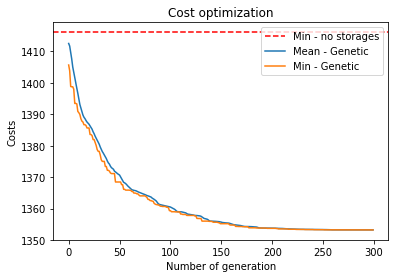

In [7]:
plt.axhline(cost_wo_storage,label='Min - no storages',linestyle='dashed',c='r')
plt.plot(mean_costs,label='Mean - Genetic')
plt.plot(min_costs,label='Min - Genetic')
plt.xlabel('Number of generation')
plt.ylabel('Costs')
plt.title('Cost optimization')
plt.legend(loc=1)
plt.savefig('plots/artificial_ga.png',dpi=200)
plt.show()

In [8]:
costs_population

array([1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774, 1353.24050774, 1353.24050774,
       1353.24050774, 1353.24050774])

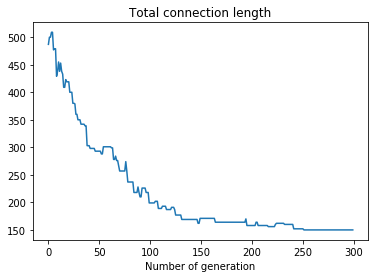

In [11]:
plt.plot(total_connections)
plt.xlabel('Number of generation')
plt.title('Total connection length')
plt.savefig('plots/genetic_optimization_distance.png',dpi=200)
plt.show()

In [10]:
population[0].print()

pv_types: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
pv_peakpowers: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
storag_conns: [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2 2 2 3 3 2 3 3 3 3 3 3 3 3 3 3
 3 3 4]
storage_capacities: [3.42105263 2.10526316 2.63157895 3.15789474 1.31578947]
storage_positions:[ 0  9 19 29 39]
